# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, Imputer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.utils import resample


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score


# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
pip install scikit-learn==0.20.4


The following command must be run outside of the IPython shell:

    $ pip install scikit-learn==0.20.4

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

# Data Exploration & Visualization

In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

#describe general population data
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [5]:
print("General population dataset has {} rows and {} columns.".format(azdias.shape[0], azdias.shape[1]))
azdias.head()

General population dataset has 891221 rows and 366 columns.


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
# Show azdias columns type counts
azdias.get_dtype_counts()

float64    267
int64       93
object       6
dtype: int64

In [7]:
#describe customer data
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [9]:
print("Customers dataset has {} rows and {} columns.".format(customers.shape[0], customers.shape[1]))
customers.head()

Customers dataset has 191652 rows and 369 columns.


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
# Show customers columns type counts
customers.get_dtype_counts()

float64    267
int64       94
object       8
dtype: int64

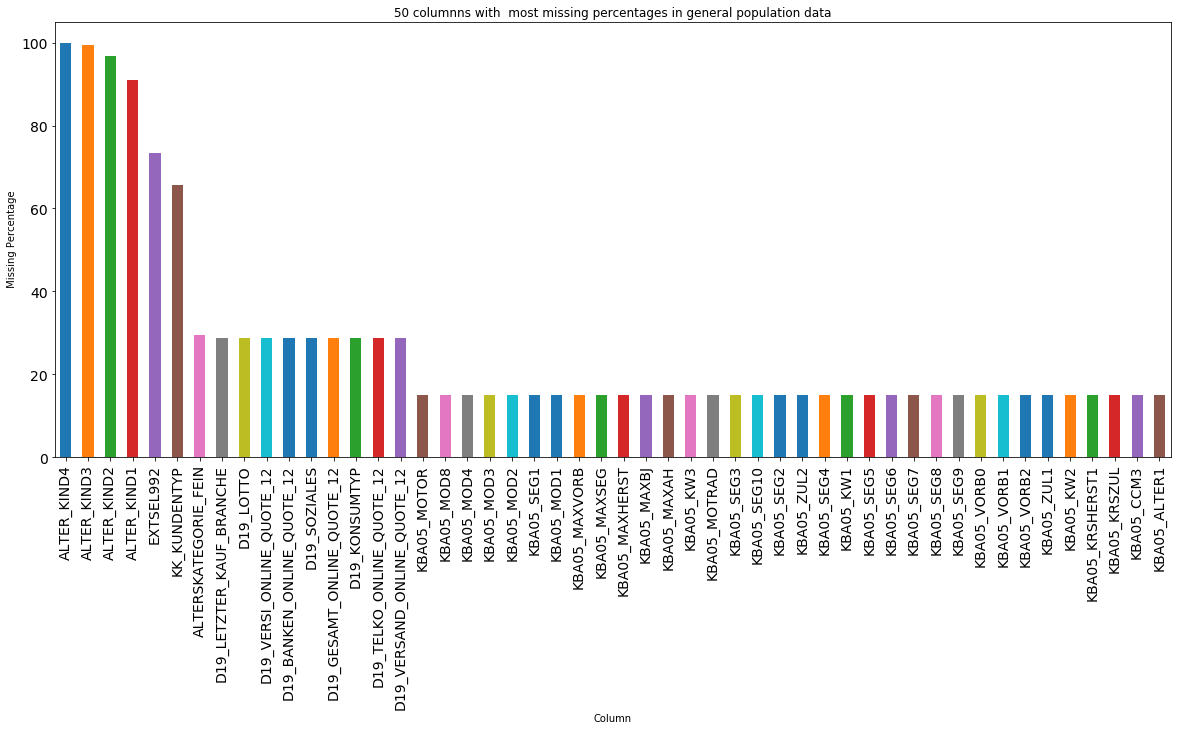

In [13]:
# find data missing data
azdias_null = azdias.isnull().sum()
azdias_null_percent = azdias_null / len(azdias) * 100
#azdias_null_percent = azdias.isnull().mean(axis=0)

customers_null =customers.isnull().sum()
customers_null_percent = customers_null / len(customers) * 100
#customers_null_percent = customers.isnull().mean(axis=0)


# visualisazion of 50 columnns with  most missing percentages in general population data
plot =(azdias_null_percent.sort_values(ascending=False)[:50].plot(kind='bar', fontsize=14, title='50 columnns with  most missing percentages in general population data', figsize=(20,8)));
plot.set(xlabel='Column', ylabel=' Missing Percentage');

In [14]:
# top 20 %s of missing data in columns in general population data
print('% of missing data in columns','\n',azdias_null_percent.sort_values(ascending=False).head(20))

% of missing data in columns 
 ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
dtype: float64


Text(0.5,1,'Percentage of NaN Values in customers Columns')

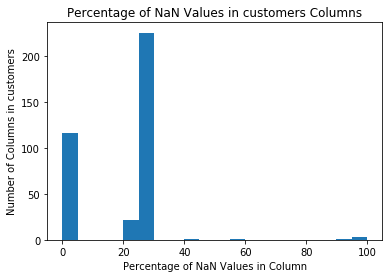

In [15]:
#visualisazion of 50 most missing percentages in customer data
#plot=(customers_null_percent.sort_values(ascending=False)[:50].plot(kind='bar', fontsize=14, title='50 columnns with  most missing percentages in customer data', figsize=(20,8)));
#plot.set(xlabel='Column', ylabel=' Missing Percentage');

plt.hist(customers_null_percent, bins=20);

plt.xlabel('Percentage of NaN Values in Column')
plt.ylabel('Number of Columns in customers')
plt.title('Percentage of NaN Values in customers Columns')

In [16]:
# top 20 %s of missing data in columns in customers data
print('% of missing data in columns','\n',customers_null_percent.sort_values(ascending=False).head(20))

% of missing data in columns 
 ALTER_KIND4      99.876860
ALTER_KIND3      99.334732
ALTER_KIND2      97.338927
ALTER_KIND1      93.860748
KK_KUNDENTYP     58.406382
EXTSEL992        44.498883
KBA05_SEG7       29.209192
KBA05_KW1        29.209192
KBA05_SEG4       29.209192
KBA05_SEG5       29.209192
KBA05_SEG6       29.209192
KBA05_MAXAH      29.209192
KBA05_SEG8       29.209192
KBA05_KW2        29.209192
KBA05_VORB0      29.209192
KBA05_KRSZUL     29.209192
KBA05_VORB1      29.209192
KBA05_KRSVAN     29.209192
KBA05_KRSOBER    29.209192
KBA05_SEG9       29.209192
dtype: float64


In [17]:
missing_perct_row = azdias.isnull().mean(axis=1)
missing_perct_row.head()

0    0.688525
1    0.040984
2    0.013661
3    0.019126
4    0.013661
dtype: float64

Text(0.5,1,'Proportion of NaN Values in azdias Rows')

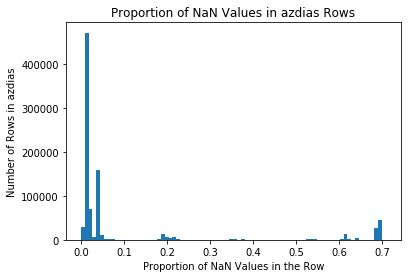

In [18]:
plt.hist(missing_perct_row, bins=80);

plt.xlabel('Proportion of NaN Values in the Row')
plt.ylabel('Number of Rows in azdias')
plt.title('Proportion of NaN Values in azdias Rows')

# Data Preprocessing

In [19]:
# Load Excel and filter for missing value classes
attr_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', usecols='B:E', dtype='str')
missing_keys = attr_values[attr_values["Meaning"].isin(["unknown","unknown / no main age detectable"])]

In [20]:
# columns in AZDIAS dataset but not described in attributes_info: to drop
azdias_columns_not_described = list(set(azdias.columns) - set(attr_values['Attribute']))
#len(azdias_columns_not_described)
azdias_columns_not_described 


['D19_VOLLSORTIMENT',
 'CJT_TYP_2',
 'UMFELD_JUNG',
 'D19_BIO_OEKO',
 'KK_KUNDENTYP',
 'FIRMENDICHTE',
 'DSL_FLAG',
 'D19_SOZIALES',
 'CJT_TYP_6',
 'D19_GARTEN',
 'D19_BANKEN_REST',
 'D19_SONSTIGE',
 'D19_BEKLEIDUNG_GEH',
 'D19_FREIZEIT',
 'CJT_TYP_5',
 'D19_TELKO_MOBILE',
 'D19_VERSI_ONLINE_DATUM',
 'D19_ENERGIE',
 'D19_SAMMELARTIKEL',
 'KBA13_CCM_1401_2500',
 'D19_HAUS_DEKO',
 'D19_BANKEN_DIREKT',
 'D19_SCHUHE',
 'VHN',
 'D19_BILDUNG',
 'KONSUMZELLE',
 'D19_VERSI_ONLINE_QUOTE_12',
 'KBA13_ANTG3',
 'GEMEINDETYP',
 'D19_REISEN',
 'D19_DIGIT_SERV',
 'CJT_KATALOGNUTZER',
 'UNGLEICHENN_FLAG',
 'D19_TIERARTIKEL',
 'CJT_TYP_4',
 'CJT_TYP_3',
 'VHA',
 'KBA13_ANTG2',
 'AKT_DAT_KL',
 'D19_LOTTO',
 'UMFELD_ALT',
 'ALTER_KIND1',
 'D19_BUCH_CD',
 'D19_TELKO_REST',
 'D19_KINDERARTIKEL',
 'D19_VERSI_DATUM',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'KBA13_HHZ',
 'STRUKTURTYP',
 'KBA13_ANTG4',
 'D19_DROGERIEARTIKEL',
 'D19_NAHRUNGSERGAENZUNG',
 'KOMBIALTER',
 'ALTERSKATEGORIE_FEIN',
 'EINGEZOGENAM_HH

In [21]:
azdias.drop(labels=azdias_columns_not_described, axis=1, inplace=True)
azdias.columns

Index(['AGER_TYP', 'ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'CAMEO_DEU_2015',
       'CAMEO_DEUG_2015', 'CJT_GESAMTTYP',
       ...
       'SEMIO_VERT', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=272)

In [22]:
customers.drop(labels=azdias_columns_not_described, axis=1, inplace=True)
customers.columns

Index(['AGER_TYP', 'ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'CAMEO_DEU_2015',
       'CAMEO_DEUG_2015', 'CJT_GESAMTTYP',
       ...
       'VERS_TYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=275)

In [23]:
azdias_null = azdias.isnull().sum()
azdias_null_percent = azdias_null / len(azdias) * 100
columns_to_drop  = azdias_null_percent[azdias_null_percent > 65].index
columns_to_drop

Index([], dtype='object')

In [22]:
# Drop the extra column of customers dataset.
#customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [23]:
#print('# of column in azdias before dropping: ', len(azdias.columns))
#azdias = azdias.drop(columns_to_drop,axis=1)
#print('# of column in azdias after dropping: ', len(azdias.columns))

#print('# of column in customers before dropping: ', len(customers.columns))
#customers = customers.drop(columns_to_drop,axis=1)
#print('# of column in customers after dropping: ', len(customers.columns))

In [1]:
# find correlation matrix    
corr_matrix = azdias.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
azdias = azdias.drop(drop_columns, axis=1)
print('number of columns', len(azdias.columns))

# repeat for customers
# find correlation matrix    
corr_matrix = customers.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
customers = customers.drop(drop_columns, axis=1)
print('number of columns', len(customers.columns))

NameError: name 'azdias' is not defined

In [24]:
# get categorical columnns
cols = azdias.columns
num_cols = azdias._get_numeric_data().columns
print('num_cols: ',num_cols)
print('categorical: ',list(set(cols) - set(num_cols)))

num_cols:  Index(['AGER_TYP', 'ALTER_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'BALLRAUM', 'CJT_GESAMTTYP',
       'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       ...
       'SEMIO_VERT', 'SHOPPER_TYP', 'TITEL_KZ', 'VERS_TYP', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=269)
categorical:  ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'OST_WEST_KZ']


In [25]:
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace(['X','XX'],-1)
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].replace(['X','XX'],-1)
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].fillna(-1)
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].fillna(-1)
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(int)
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].astype(int)
azdias[['CAMEO_DEU_2015','OST_WEST_KZ']]=azdias[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
customers[['CAMEO_DEU_2015','OST_WEST_KZ']]=customers[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)

In [ ]:
df=azdias[missing_perct_row < 0.2]
df.shape


In [15]:
azdias=df
azdias.columns[azdias.isnull().any()]
#azdias.head()

Index(['ANZ_HH_TITEL', 'BALLRAUM', 'CJT_GESAMTTYP',
       'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12',
       'D19_KONSUMTYP', 'D19_VERSAND_ONLINE_QUOTE_12', 'EWDICHTE',
       'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'INNENSTADT', 'KBA05_ALTER1',
       'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2',
       'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_GBZ',
       'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4',
       'KBA05_HERST5', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2',
       'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN',
       'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH',
       'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB',
       'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8

In [27]:
azdias.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,-1,0.0,11.0,0.0,2.0,0.0,6.0,8A,8,5.0,...,1,3,0.0,2,3.0,9.0,4.0,5,2,1
2,-1,17.0,10.0,0.0,1.0,0.0,2.0,4C,4,3.0,...,4,2,0.0,1,3.0,9.0,2.0,5,2,3
3,2,13.0,1.0,0.0,0.0,0.0,4.0,2A,2,2.0,...,4,1,0.0,1,NaN,9.0,7.0,3,2,4
4,-1,20.0,3.0,0.0,4.0,0.0,2.0,6B,6,5.0,...,7,2,0.0,2,2.0,9.0,3.0,4,1,3
5,3,10.0,5.0,0.0,1.0,0.0,6.0,8C,8,2.0,...,2,0,0.0,2,6.0,9.0,7.0,4,2,1


In [16]:
azdias.describe()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,773134.000000,773134.000000,773134.000000,769713.000000,773134.000000,773134.000000,772585.000000,773134.000000,768705.000000,773134.000000,...,773134.000000,773134.000000,773134.000000,773134.000000,741319.000000,773134.000000,773134.000000,773134.000000,773134.000000,773134.000000
mean,-0.295759,10.908206,8.357365,0.040402,1.737002,0.004122,4.148289,5.523041,3.500767,0.133184,...,4.262009,1.453112,0.003439,1.407019,4.028181,7.952722,4.062423,3.386148,1.521514,2.819390
std,1.234200,7.622160,15.613365,0.317479,1.162200,0.068085,2.185223,2.526260,1.536544,0.557322,...,1.937685,1.137391,0.084450,0.718863,1.902459,1.893953,1.923085,1.406997,0.499537,1.080641
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,0.000000,...,1.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,-1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,2.000000,3.000000,2.000000,0.000000,...,2.000000,1.000000,0.000000,1.000000,3.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,-1.000000,13.000000,4.000000,0.000000,1.000000,0.000000,5.000000,6.000000,4.000000,0.000000,...,5.000000,1.000000,0.000000,1.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,1.000000,17.000000,10.000000,0.000000,2.000000,0.000000,6.000000,8.000000,5.000000,0.000000,...,6.000000,2.000000,0.000000,2.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,3.000000,21.000000,595.000000,20.000000,45.000000,4.000000,7.000000,9.000000,6.000000,6.000000,...,7.000000,3.000000,5.000000,2.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [ ]:
imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)

azdias1 = imputer.fit_transform(azdias)
azdias = pd.DataFrame(azdias1)
print('imputed azdias: ', azdias.head(5))

customers1 = imputer.fit_transform(customers)
customers = pd.DataFrame(customers1)
print('imputed customers: ', customers.head(5))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [39]:
print('Total rows in new azdias dataset: ',azdias.shape)
print('Total rows in new customers dataset: ',customers.shape)

number of rows in new dataset:  (891221, 178)
number of rows in new dataset:  (191652, 193)


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')